<font color="red"><h1>OpenSees Examples Manual using OpenSeesPy!</h1></font> 

You can find the original OpenSees examples manual using Tcl [here](https://opensees.berkeley.edu/wiki/index.php/Examples_Manual). (Original Examples in Tcl by Silvia Mazzoni & Frank McKenna, 2006.)

<h2><u>Simulation Process</u></h2>

In the following example, an input file (python script) is created to conduct a simulation in OpenSees. The process of creating the input file is broken-down into three main parts: 
### 1. Model definition (General)
### 2. Output specification
### 3. Loads and Analysis
- Model definition (Gravity loads)
- Analysis generation (Gravity loads)
- Model definition (Lateral loads)
- Analysis generation (Lateral loads)




<h2><u>OpenSees Example 1a</u></h2>

### 2D Elastic Cantilever Column -- Static Pushover

This example has previously been converted to OpenSeesPy by SilviaMazzoni, 2020. The script can be found on her github page [here](https://github.com/silviamazzoni/OpenSeesPy_ExamplesManual/blob/main/BraineryBytes_OpenSees_Examples_Manual_Example_1a_Elastic_Cantilever_Column_Pushover.ipynb).

Introductory example 1a is a simple model of an elastic cantilever column. 

<img src="https://opensees.berkeley.edu/wiki/images/e/ec/Example1a_Push.GIF">


In [1]:
# Import required modules
import openseespy.opensees as ops  # OpenSeesPy: The Python interface for OpenSees, used for finite element analysis.
import opsvis as opsv  # Visualization tool for OpenSees models.
import os  # Provides functions for interacting with the operating system.
import numpy as np  # Python library used for scientific computing
import matplotlib.pyplot as plt  # Plotting library for data visualization.

In [2]:
# Check if a directory named 'Data' exists; if not, create one.
# This directory will store any data or results generated during the simulation.
if not os.path.exists('Data'): 
    os.mkdir('Data')

## Units

In [3]:
# Defining base units for the simulation.
m = 1.0  # Meter (base unit for length)
s = 1.0  # Second (base unit for time)
kg = 1.0  # Kilogram (base unit for mass)

# Derived units for force and pressure.
N = kg * m / s ** 2  # Newton (unit of force)
Pa = N / m ** 2  # Pascal (unit of pressure)

# Additional conversions for different units commonly used in structural engineering.
inches = 0.0254 * m  # Conversion factor for inches to meters.
ft = 12 * inches  # Conversion factor for feet to meters.
kip = 4448.2216152548 * N  # Conversion factor for kips (1000 pounds-force) to Newtons.
ksi = 6.895 * 10 ** 6 * Pa  # Conversion factor for ksi (1000 psi) to Pascals.

## Input Variables

In [5]:
colL = 36 * ft # Column length

# Nodal coordinates
n1 = (0.0, 0.0) # Use floating point values
n2 = (0.0, colL)

# Cross-sectional dimensions
b = 5 * ft # Breadth
d = 5 * ft # Depth
A = b * d # Area

# Elastic Modulus
E = 4227 * ksi

# Moment of Inertia
Iz = (b * d ** 3) / 12

# Loads/Actions
Py = -2000.0 * kip # Gravity load

We will perform a displacement-controlled static analysis, so any non-zero value for the lateral load can be used. The specific value of the lateral load will not affect the results.

In [30]:
Px = 1 # Lateral load

g = 9.81 # Gravitational acceleration (N / kg)

# Compute nodal mass
mass_x = abs(Py) / g # kg
print(f'The nodal mass value corresponding to the horizontal DOF is {mass_x:.0f} kg') # 
massValues = [mass_x, 1 * 10 ** -9, 0.0] # ndf nodal mass values corresponding to each DOF


The nodal mass value corresponding to the horizontal DOF is 906875 kg


<font color="red">Note to self:
- Explain the reason for defining mass when we are performing a static analysis
- Explain the purpose of assigning the vertical nodal mass value a very small number</font> 

## Model definition (General)

**Wipe command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/wipe.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Wipe_Command)

The wipe command is used to clear or reset the current model, removing all definitions, including nodes, elements, materials, constraints, and loads from memory.
You would typically use ops.wipe() at the beginning of a new analysis or simulation to ensure that any previous model definitions do not affect your current work

In [7]:
ops.wipe()  # Clear opensees model

**Model command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/model.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Model_command)

The model command is used to create a ModelBuilder object, which establishes the fundamental framework for building a finite element model. A ModelBuilder object defines the type of model, the number of spatial dimensions, and the global default number of degrees of freedom per node. It determines the set of commands available for constructing the model. Once the ModelBuilder is defined, the user can create elements, nodes, load patterns, and other objects that make up the model. 

You can think of the ModelBuilder object as a template that sets up the basic structure of the model and defines the rules for how different components interact.

The 'basic' ModelBuilder is the primary and, as of now, only implemented ModelBuilder type. It provides all the necessary functionality to create a wide range of finite element models.



In [8]:
ops.model('basic', '-ndm', 2, '-ndf', 3)    # 2D model with 3 degrees of freedom per node.

**Node command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/node.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Node_command)

The node command is used to define a node in the finite element model. It allows users to define nodes with specific properties, customise their degrees of freedom, and set initial conditions to suit various types of analyses, including static and dynamic simulations.

The nodeTag is a unique identifier (integer) for the node. Each node in the model must have a unique nodeTag to distinguish it from other nodes.

In [9]:
# Create nodes
nodal_crds = (n1, n2)
for nodeTag, crds in enumerate(nodal_crds, start = 1): # https://docs.python.org/3/library/functions.html#enumerate
    ops.node(nodeTag, *crds)

**Fix command**:  [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/src/fix.html), [OpenSees Tcl](https://opensees.berkeley.edu/wiki/index.php?title=Fix_command)

The fix command is used to define the boundary conditions or constraints at a specific node in the model. This command specifies which degrees of freedom (DOFs) at a node are fixed and which are free to move.

In a 2D model, each node typically has 3 DOFs. The contraint values (constrValues) correspond to the DOFs: ux, uy, rz.  
In a 3D model, each node typically has 6 DOFs. The contraint values (constrValues) correspond to the DOFs: ux, uy, uz, rx, ry, rz.

Note: By default, all nodes in OpenSeesPy are considered free (unconstrained) unless explicitly constrained using commands like ops.fix.

In [10]:
# Boundary Conditions - single point constraints
constrValues = [1, 1, 1]
ops.fix(1, *constrValues)   # Node 1 is a fixed connection
# ops.fix(2, 0, 0, 0)         # Node 2 is free

**opsv.plot_model command**:  [opsvis](https://opsvis.readthedocs.io/en/latest/plot_model.html)

The opsv.plot_model() command is used to visualise the model that has been created using the OpenSeesPy library. The visualisation provides a graphical representation, allowing the user to check if the model's setup is correct and matches the intended design.

Text(0.5, 1.0, 'plot_model after defining nodes')

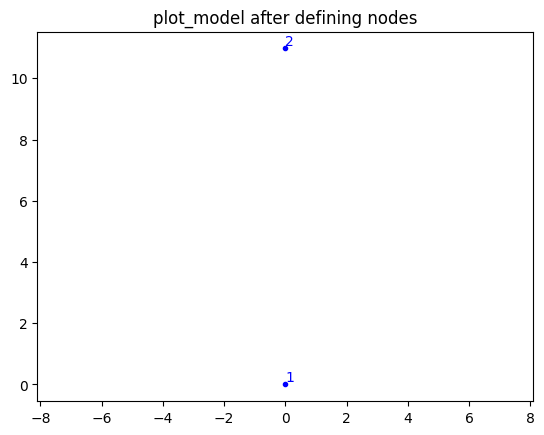

In [11]:
opsv.plot_model()
plt.title('plot_model after defining nodes')

In [12]:
# Define ELEMENTS -------------------------------------------------------------
# define geometric transformation: performs a linear geometric transformation of beam stiffness
# and resisting force from the local-coordinate system to the global-coordinate system
# geomTransf('Linear', transfTag, '-jntOffset', *dI, *dJ)
ops.geomTransf('Linear', 1)     #  associate a tag to transformation

In [13]:
# # Define Materials
# ops.uniaxialMaterial("Elastic", 1, E)

In [14]:
# connectivity: (make A very large, 10e6 times its actual value)
# element elasticBeamColumn eleTag iNode jNode A E Iz transfTag
ops.element('elasticBeamColumn', 1, 1, 2, A * 10 ** 6, E, Iz, 1)     # element elasticBeamColumn 1 1 2 3600000000 4227 1080000 1;

Text(0.5, 1.0, 'plot_model after defining elements')

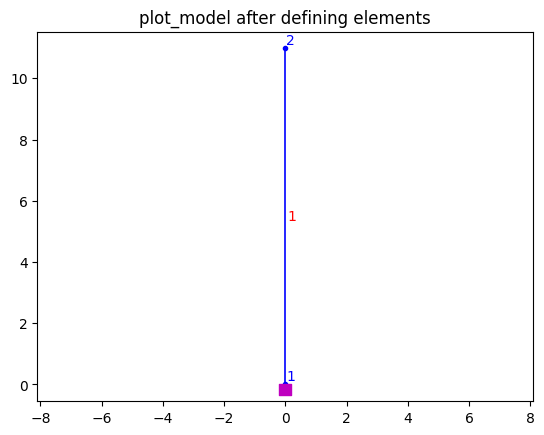

In [15]:
opsv.plot_model()
plt.title('plot_model after defining elements')

In [16]:
# nodal masses: Time - 23:30, 32:20
ops.mass(2, *massValues)     #  node ,  Mass=Weight/g.

## Output specification

In [17]:
# Define RECORDERS -------------------------------------------------------------

# https://openseespydoc.readthedocs.io/en/latest/src/nodeRecorder.html#node-recorder-command
# recorder('Node', '-file', filename, '-time', '-node', *nodeTags=[], '-dof', *dofs=[], respType)
dofs = [1, 2, 3]
ops.recorder('Node', '-file', 'Data/DispFreeEx1aPush.out', '-time', '-node', 2, '-dof', *dofs, 'disp')     #  displacements of free node
ops.recorder('Node', '-file', 'Data/DispBaseEx1aPush.out', '-time', '-node', 1, '-dof', *dofs, 'disp')     #  displacements of support node
ops.recorder('Node', '-file', 'Data/ReacBaseEx1aPush.out', '-time', '-node', 1, '-dof', *dofs, 'reaction')     #  support reaction

# https://openseespydoc.readthedocs.io/en/latest/src/elementRecorder.html#element-recorder-command
# recorder('Element', '-file', filename, '-time', '-ele', *eleTags=[], '-eleRange', startEle, endEle, '-region', regionTag, *args)
ops.recorder('Element', '-file', 'Data/FColEx1aPush.out', '-time', '-ele', 1, 'globalForce')     #  element forces -- column
ops.recorder('Element', '-file', 'Data/DColEx1aPush.out', '-time', '-ele', 1, 'deformation')     #  element deformations -- column

4

## Loads and Analysis

### Model definition (Gravity Loads)

In [18]:
# Define GRAVITY Loads-------------------------------------------------------------
ops.timeSeries('Linear', 1)  # timeSeries Linear 1;

# Define Load Pattern
ops.pattern('Plain', 1, 1)
ops.load(2, 0.0, Py, 0.0)   #  node , FX FY MZ -- superstructure-weight

### Analysis generation (Gravity loads)

In [19]:
ops.wipeAnalysis()     # adding this to clear Analysis module 
ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis
ops.numberer('Plain')     #  renumber dofs to minimize band-width (optimization), if you want to
ops.constraints('Plain')     #  how it handles boundary conditions
ops.integrator('LoadControl',0.1)     #  determine the next time step for an analysis,   apply gravity in 10 steps
ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
ops.analysis('Static')     #  define type of analysis static or transient

ops.test('NormDispIncr',1.0e-8,6)     #  determine if convergence has been achieved at the end of an iteration step
ops.analyze(10)     #  perform gravity analysis
ops.loadConst('-time',0.0)     #  hold gravity constant and restart time

100


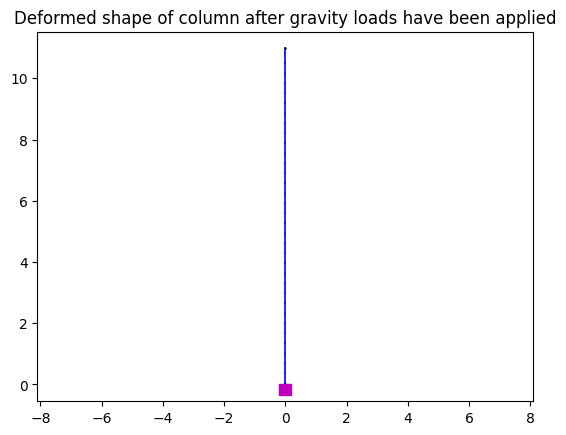

In [20]:
sfac = opsv.plot_defo(sfac = 100)
plt.title('Deformed shape of column after gravity loads have been applied')
print(sfac)

### Model definition (Lateral loads)

In [21]:
# define LATERAL load -------------------------------------------------------------
# Lateral load pattern
ops.timeSeries('Linear', 2)     # timeSeries Linear 2;
# define Load Pattern
ops.pattern('Plain', 2, 2) # 
ops.load(2, Px, 0.0, 0.0)    #  node , FX FY MZ -- REPRESENTATIVE lateral load at top node

### Analysis generation (Lateral loads)

In [22]:
# pushover: diplacement controlled static analysis
# Note we do not wipe the analysis

disp = 100 * inches
print(f'Horizontal displacement at top of column is set to be: {disp} metres')
steps = 1000 # Must be an integer
incr = disp / steps
ops.integrator('DisplacementControl', 2, 1, incr)     #  switch to displacement control, for node 2, dof 1, 0.1 increment
ops.analyze(steps)

Horizontal displacement at top of column is set to be: 2.54 metres


0

In [23]:
print('Done!')

Done!


## Output

Text(0.5, 1.0, 'Deformed shape of column (Scale factor: 1)')

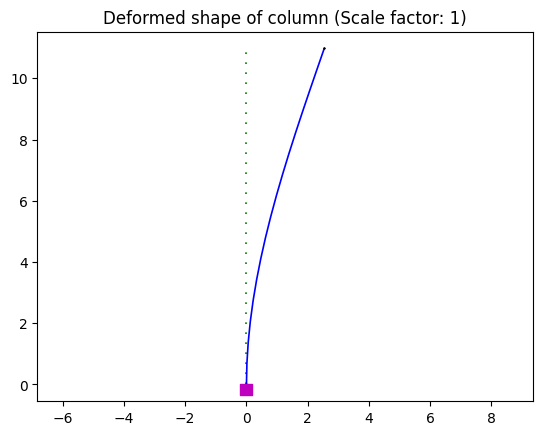

In [24]:
sfac = opsv.plot_defo(sfac = 1)
plt.title(f'Deformed shape of column (Scale factor: {sfac})')

Display the applied loads.

<Axes: >

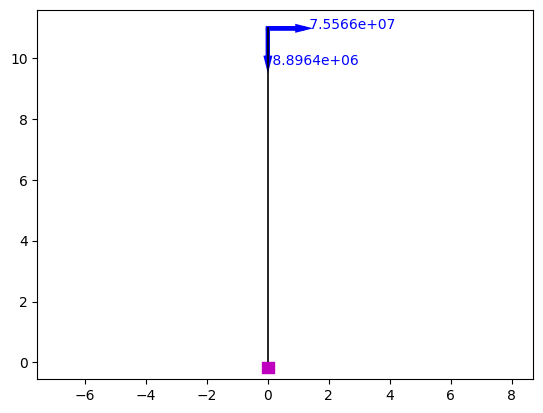

In [25]:
opsv.plot_loads_2d(nep=17, sfac=False, fig_wi_he=False, fig_lbrt=False, 
                   fmt_model_loads={'color': 'black', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '', 'markersize': 1}, 
                   node_supports=True, truss_node_offset=0, ax=False)

The lateral load shown above is the load required to produce the specified horizontal displacement assuming the column remains elastic. We can check/compare this value with that given by the theoretical formula for maximum displacement of a cantilever beam with a point load at its free end.

In [26]:
# Check the applid horizontal load produces the expected displacement (Include picture of theoretical formula)
expected_disp = (7.5566 * 10 ** 7 * colL ** 3) / (3 * E * Iz)
print(f'Maximum displacement: {expected_disp:.3f} m')

Maximum displacement: 2.540 m


As expected, this agrees with the displacement we specified for the displacement controlled analysis.

In [27]:
ops.printModel()

Current Domain Information
	Current Time: 7.55662e+07
	Committed Time: 7.55662e+07
NODE DATA: NumNodes: 2

numComponents: 2

 Node: 1
	Coordinates  : 0 0 
	Disps: 0 0 0 
	 unbalanced Load: 0 0 0 
	 reaction: -7.55662e+07 8.89644e+06 8.29173e+08 
	ID : -1 -1 -1 


 Node: 2
	Coordinates  : 0 10.9728 
	Disps: 2.54 -1.44211e-09 -0.347222 
	 unbalanced Load: 7.55662e+07 -8.89644e+06 0 
	 reaction: -2.98023e-08 0 -1.19209e-07 
	Mass : 
906875 0 0 
0 1e-09 0 
0 0 0 

	 Rayleigh Factor: alphaM: 0
	 Rayleigh Forces: 0 0 0 
	ID : 0 1 2 

ELEMENT DATA: NumEle: 1

numComponents: 1

ElasticBeam2d: 1
	Connected Nodes: 1 2 
	CoordTransf: 1
	mass density:  0, cMass: 0
	release code:  0
	End 1 Forces (P V M): 8.89644e+06 7.55662e+07 8.29173e+08
	End 2 Forces (P V M): -8.89644e+06 -7.55662e+07 -1.19209e-07

SP_Constraints: numConstraints: 3

numComponents: 3
SP_Constraint: 0	 Node: 1 DOF: 1 ref value: 0 current value: 0 initial value: 0
SP_Constraint: 1	 Node: 1 DOF: 2 ref value: 0 current value: 0 init

End of Run


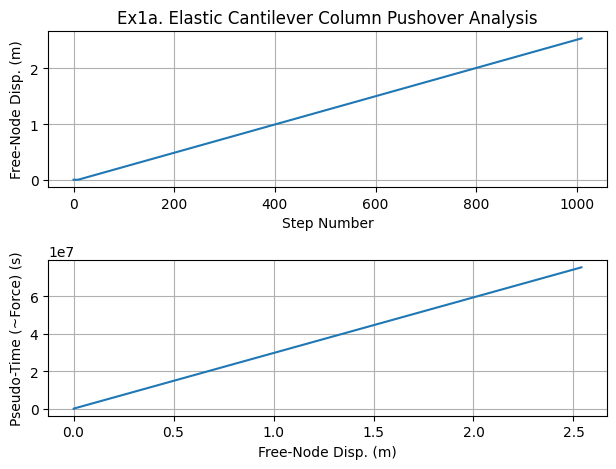

In [28]:
# Load the data
fname3 = 'Data/DispFreeEx1aPush.out'
dataDFree = np.loadtxt(fname3)

# Create a figure and axes instances
fig, axes = plt.subplots(2, 1)

# Plot on the first axis
axes[0].set_title('Ex1a. Elastic Cantilever Column Pushover Analysis')
axes[0].grid(True)
axes[0].plot(dataDFree[:, 1])
axes[0].set_xlabel('Step Number')
axes[0].set_ylabel('Free-Node Disp. (m)')

# Plot on the second axis
axes[1].grid(True)
axes[1].plot(dataDFree[:, 1], dataDFree[:, 0])
axes[1].set_xlabel('Free-Node Disp. (m)')
axes[1].set_ylabel('Pseudo-Time (~Force) (s)')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap

# End of script
print('End of Run')